# 程式 5.1: 介紹多程序處理

In [1]:
import multiprocessing as mp
# from multiprocess import queues
import numpy as np
def square(x): #將陣列輸入此函數後，該函數會將陣列中的數字分別進行平方 
  return np.square(x)
x = np.arange(64) #生成內有數字序列的陣列
print(x) #印出陣列中的數字

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [2]:
mp.cpu_count() #輸出CPU數量，結果因電腦而異

4

In [ ]:
pool = mp.Pool(8) #建立內含8個程序的多程序池（processor pool)
squared = pool.map(square, [x[8*i:8*i+8] for i in range(8)]) #使用多程序池的.map()，對陣列中的每個數字呼叫square()，並將結果存入串列中傳回
squared #印出結果串列

# 程式 5.2: 用手動方式開啟多程序

In [ ]:
def square(i, x, queue):
  print("In process {}".format(i,))
  queue.put(np.square(x)) #將輸出結果存進queue

processes = [] #建立用來儲存不同程序的串列
queue = mp.Queue() #建立多程序處理的Queue；該資料結構可以被不同的程序共享
x = np.arange(64) #生成一個數列做為目標數列（內含0～63的整數）
for i in range(8): #開啟8條程序，並讓它們利用square函式分別處理目標數列中的一部份資料
  start_index = 8*i
  proc = mp.Process(target=square,args=(i,x[start_index:start_index+8], queue)) 
  proc.start()
  processes.append(proc)
    
for proc in processes: #{待所有程序皆執行完畢後，再將結果傳回主執行緒
  proc.join()
    
for proc in processes: #終止各程序
  proc.terminate()

results = []
while not queue.empty(): #將queue內的資料存進results串列，至到資料已清空
  results.append(queue.get())

In [ ]:
results

# 程式 5.3：優勢演員 - 評論家的虛擬碼

In [ ]:
# gamma = 0.9
# for i in epochs: #重複訓練 epochs 次
#  state = environment.get_state() #取得環境目前的狀態
#  value = critic(state) #價值網路預測目前狀態的價值
#  policy = actor(state) #策略網路預測目前狀態下各動作的機率分佈
#  action = policy.sample() #根據策略網路輸出的機率分佈選擇動作
#  next_state, reward = environment.take_action(action) #執行動作，產生新狀態及回饋值
#  value_next = critic(next_state) #預測新狀態的價值
#  advantage = (reward + gamma * value_next) - value #優勢值函數
#  loss =-1 * policy.logprob(action) * advantage #根據動作的優勢值來強化（或弱化）該動作
#  minimize(loss) #想辦法最小化損失

# 程式 5.4： Cartpole演員-評論家模型

In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp 
import matplotlib
import matplotlib.pyplot as plt

class ActorCritic(nn.Module): #定義演員—評論家模型
  def __init__(self):
    super(ActorCritic, self).__init__()
    self.l1 = nn.Linear(4,25) #定義模型中各神經層的shape，參考圖5.10
    self.l2 = nn.Linear(25,50)
    self.actor_lin1 = nn.Linear(50,2)
    self.l3 = nn.Linear(50,25)
    self.critic_lin1 = nn.Linear(25,1)
  def forward(self,x):
    x = F.normalize(x,dim=0) #正規化輸入資料
    y = F.relu(self.l1(x))
    y = F.relu(self.l2(y))
    actor = F.log_softmax(self.actor_lin1(y),dim=0) #演員端輸出遊戲中兩種可能動作的對數化機率值
    c = F.relu(self.l3(y.detach())) #先將評論家段的節點分離，再經過ReLU的處理
    critic = torch.tanh(self.critic_lin1(c)) #評論家端輸出一個範圍在–1到+1之間的純量
    return actor, critic #使用tuple傳回演員和評論家的輸出結果

## 設置gym環境

In [2]:
!pip install gym[classic_control]


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


## 由於要先運行程式5.6至程式5.8，因此將程式5.5移至後面

# 程式 5.6： 主要訓練迴圈

In [3]:
from IPython.display import clear_output
def worker(t, worker_model, counter, params):
  worker_env = gym.make("CartPole-v1")
  worker_env.reset()
  worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters()) #每條程序有獨立的運行環境和優化器，但共享模型參數
  worker_opt.zero_grad()
  for i in range(params['epochs']):
    worker_opt.zero_grad()
    values, logprobs, rewards, length = run_episode(worker_env,worker_model) #呼叫run_episode( )來執行一場遊戲並收集資料（譯註：該函式的定義見程式5.7）
    actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards) #使用所收集的資料來更新神經網路參數（譯註：update_params( )的定義見程式5.8）
    counter.value = counter.value + 1 # counter是一個全域計數器，被所有程序共享
    if(i%10 == 0): #印出當前的訓練進度
      print(i)
      print(len(rewards))
      clear_output(wait=True)
    buffer.put(length) #將遊戲長度存進buffer中

# 程式 5.7： 執行一場遊戲

In [4]:
def run_episode(worker_env, worker_model):
  state = torch.from_numpy(worker_env.env.state).float() #將環境狀態的資料型態從NumPy陣列轉換為PyTorch張量
  values, logprobs, rewards = [],[],[] #建立三個串列，分別用來儲存狀態價值（評論家）、對數化機率分佈（演員）、以及回饋值
  done = False
  j=0
  while (done == False): #除非滿足結束條件，否則遊戲繼續進行
    j+=1
    policy, value = worker_model(state) #計算狀態價值以及各種可能動作的對數化機率
    values.append(value)
    logits = policy.view(-1) #呼叫.view(-1) 將對數化機率轉成向量形式
    action_dist = torch.distributions.Categorical(logits=logits)
    action = action_dist.sample() #參考演員所提供的對數化機率來選擇動作
    logprob_ = policy.view(-1)[action]
    logprobs.append(logprob_)
    state_, _, done,_, info = worker_env.step(action.detach().numpy())
    state = torch.from_numpy(state_).float()
    if done: #{3}若某動作造成遊戲結束，則將回饋值設為–10，並且重置環境
      reward = -10
      worker_env.reset()
    else:
      reward = 1.0
    rewards.append(reward)
  return values, logprobs, rewards, len(rewards)

# 程式 5.8： 計算並最小化損失

In [5]:
def update_params(worker_opt,values,logprobs,rewards,clc=0.1,gamma=0.95):
  rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) #{3}將rewards、logprobs及values陣列中的元素順序顛倒
  logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
  values = torch.stack(values).flip(dims=(0,)).view(-1)
  Returns = []
  ret_ = torch.Tensor([0])
  for r in range(rewards.shape[0]): #使用順序巔倒後的回饋值來計算每一步的回報，並將結果存入Returns陣列中
    ret_ = rewards[r] + gamma * ret_
    Returns.append(ret_)
  Returns = torch.stack(Returns).view(-1)
  Returns = F.normalize(Returns,dim=0) #將Returns陣列中的值做正規化處理
  actor_loss = -1*logprobs * (Returns - values.detach()) #將values張量的節點從運算圖中分離，並計算演員的損失，以避免其反向傳播到評論家端
  critic_loss = torch.pow(values - Returns,2) #計算評論家的損失
  loss = actor_loss.sum() + clc*critic_loss.sum() #將演員和評論家的損失加起來，變成總損失。注意，我們使用clc參數來降低評論家損失的影響
  loss.backward()
  worker_opt.step()
  return actor_loss, critic_loss, len(rewards)

# 程式 5.5： 分散式訓練

3500
3500 0


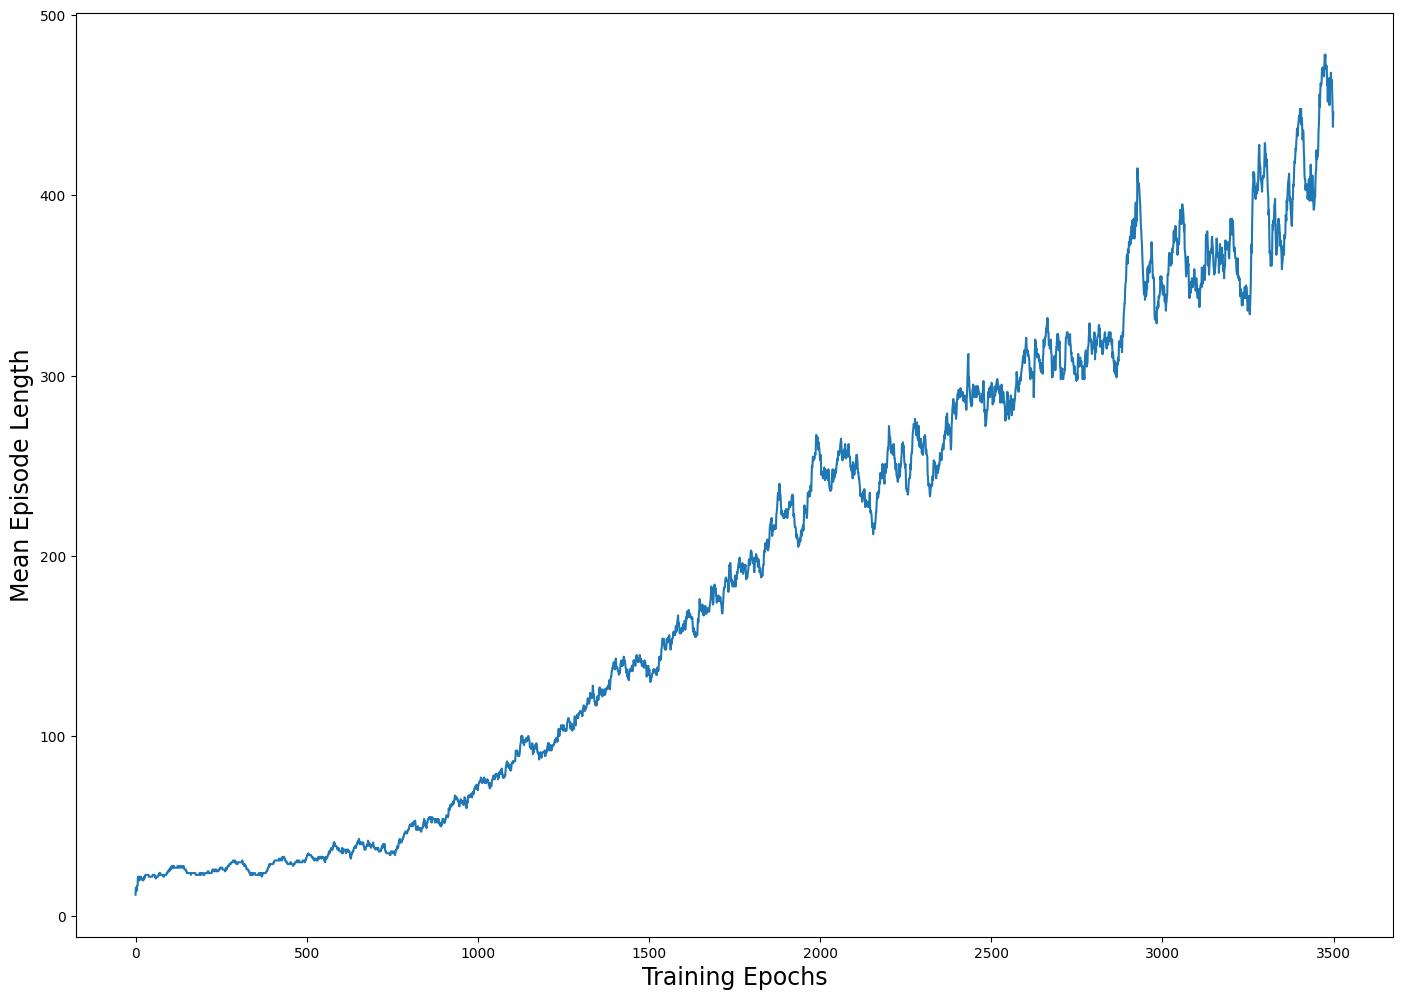

In [7]:
MasterNode = ActorCritic() #建立一個共享的全域演員—評論家實例
MasterNode.share_memory() # share_memory()允許不同程序共用同一組模型參數（無須複製參數，節省空間）
processes = [] #用來儲存不同程序實例的串列
params = {
    'epochs':500, #進行500次訓練
    'n_workers':7, #設定程序數目為7
}
counter = mp.Value('i',0) #使用multiprocessing函式庫創建一個全域計數器，參數『i』代表其資料型態為整數
buffer = mp.Queue() #編註：小編在這裡創建了一個buffer，用來儲存每一場的遊戲長度（多少回合）
for i in range(params['n_workers']):
  p = mp.Process(target=worker, args=(i,MasterNode,counter,params)) #啟動新的程序來運行worker函式（譯註：該函式的定義見程式5.6）
  p.start() 
  processes.append(p)
for p in processes: #{2}利用join讓每條程序皆完成運算後，再將結果傳回
  p.join()
for p in processes: #{2}終止各程序
  p.terminate()

#小編補充：原文沒有畫出平均遊戲長度的程式，因此小編加上了以下程式：
n = params['n_workers']
score = []
running_mean = []
total = torch.Tensor([0])
mean = torch.Tensor([0])
while not buffer.empty():
  score.append(buffer.get()) #將buffer中的資料存入score
print(len(score))
for i in range (params['epochs']):
  if (i>=50): #若訓練次數已超過50，則計算過去50場遊戲的平均長度
    total = total - sum(score[n*(i-50) : n*(i-50)+n])/n
    total = total + sum(score[n*i : n*i+n])/n 
    mean = int(total/50) 
  else: #若訓練次數未超過50次，則計算到目前為止的平均遊戲長度
    total = total + sum(score[n*i : n*i+n])/n
    mean = int(total/(i+1))
  running_mean.append(mean)
plt.figure(figsize=(17,12))
plt.ylabel("Mean Episode Length",fontsize=17)
plt.xlabel("Training Epochs",fontsize=17)
plt.plot(running_mean)
#
print(counter.value, processes[0].exitcode) #列印全域計數器的值、以及第一個程序的退出碼（exit code，此值應為0）


# 程式 5.9： 使用N步學習來訓練Cartpole代理人


In [2]:
def run_episode(worker_env, worker_model, N_steps=100):
  raw_state = np.array(worker_env.env.state)
  state = torch.from_numpy(raw_state).float()
  values, logprobs, rewards = [],[],[]
  done = False
  j=0
  check = 1
  G=torch.Tensor([0]) #變數G代表回報，它的初始值為0
  while (j < N_steps and done == False): #持續進行遊戲，直到經過了N步、或者遊戲結束
    j+=1
    policy, value = worker_model(state)
    values.append(value)
    logits = policy.view(-1)
    action_dist = torch.distributions.Categorical(logits=logits)
    action = action_dist.sample()
    logprob_ = policy.view(-1)[action]
    logprobs.append(logprob_)
    state_, _, done, info = worker_env.step(action.detach().numpy())
    state = torch.from_numpy(state_).float()
    if done:
      reward = -10
      worker_env.reset()
      check = 1
    else: #若遊戲並未結束，令回報值等於最新的狀態價值
      reward = 1.0
      G = value.detach()
      check = 0
    rewards.append(reward)
  return values, logprobs, rewards, G, check

## Bonus - worker函式

In [3]:
def worker(t, worker_model, counter, params, buffer):
  worker_env = gym.make("CartPole-v1")
  worker_env.reset()
  worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters()) 
  worker_opt.zero_grad()
  tot_rew = torch.Tensor([0]) 
  for i in range(params['epochs']):
    worker_opt.zero_grad()        
    values, logprobs, rewards, G, check = run_episode(worker_env,worker_model) 
    actor_loss,critic_loss,tot_rew = update_params(worker_opt,values,logprobs,rewards,G) 
    while(check == 0):
      worker_opt.zero_grad()
      values, logprobs, rewards, G, check = run_episode(worker_env,worker_model) 
      actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards,G) 
      tot_rew += eplen
    counter.value = counter.value + 1 
    if(i%10 == 0):
      print(i)
      print(tot_rew)
      clear_output(wait=True)
    buffer.put(tot_rew) 

## Bonus - update_params函式

In [4]:
def update_params(worker_opt,values,logprobs,rewards,G,clc=0.1,gamma=0.95):
  rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) 
  logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
  values = torch.stack(values).flip(dims=(0,)).view(-1)
  Returns = []
  ret_ = G #用G來代替原本的torch.Tensor([0])
  for r in range(rewards.shape[0]): 
      ret_ = rewards[r] + gamma * ret_
      Returns.append(ret_)
  Returns = torch.stack(Returns).view(-1)
  Returns = F.normalize(Returns,dim=0)
  actor_loss = -1*logprobs * (Returns - values.detach()) 
  critic_loss = torch.pow(values - Returns,2) 
  loss = actor_loss.sum() + clc*critic_loss.sum() 
  loss.backward()
  worker_opt.step()
  return actor_loss, critic_loss, len(rewards)

##Bonus - 重建模型

In [5]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp 
import matplotlib
import matplotlib.pyplot as plt

class ActorCritic(nn.Module): #定義演員—評論家模型
  def __init__(self):
    super(ActorCritic, self).__init__()
    self.l1 = nn.Linear(4,25)
    self.l2 = nn.Linear(25,50)
    self.actor_lin1 = nn.Linear(50,2)
    self.l3 = nn.Linear(50,25)
    self.critic_lin1 = nn.Linear(25,1)
  def forward(self,x):
    x = F.normalize(x,dim=0)
    y = F.relu(self.l1(x))
    y = F.relu(self.l2(y))
    actor = F.log_softmax(self.actor_lin1(y),dim=0) #模型的演員端輸出遊戲中兩種可能動作的對數化機率值
    c = F.relu(self.l3(y.detach()))
    critic = torch.tanh(self.critic_lin1(c)) #模型的評論家端輸出一個範圍在–1到+1之間的純量
    return actor, critic #使用tuple資料型態傳回演員和評論家的輸出結果

## Bonus - 測試N-步學習法（程式5.9將N定為了100）

/home/oraika0/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Process Process-11:
Traceback (most recent call last):
  File "/home/oraika0/.pyenv/versions/3.9.1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/oraika0/.pyenv/versions/3.9.1/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_16012/932646754.py", line 9, in worker
    values, logprobs, rewards, G, check = run_episode(worker_env,worker_model)
  File "/tmp/ipykernel_16012/1009756256.py", line 18, in run_episode
    state_, _, done, info = worker_env.step(action.detach().numpy())
ValueError: too many values to unpack (expected 4)
/home/oraika0/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gym/utils/passive_env_checke

0
0 1


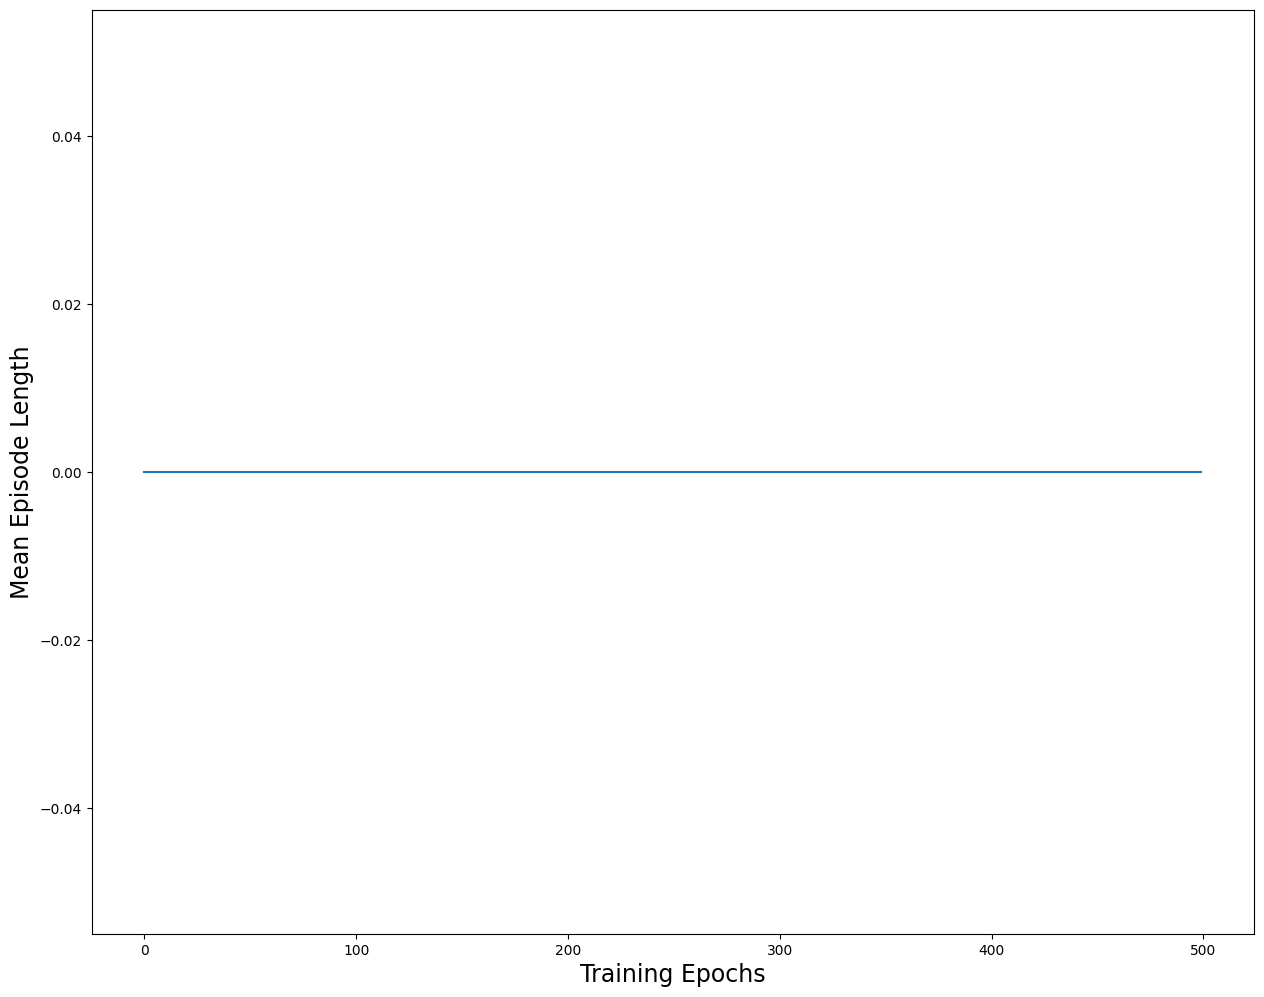

In [7]:
MasterNode = ActorCritic() #A
MasterNode.share_memory() #B
processes = [] #C
params = {
    'epochs':500,
    'n_workers':7,
}
buffer = mp.Queue()
counter = mp.Value('i',0) #D
for i in range(params['n_workers']):
  p = mp.Process(target=worker, args=(i,MasterNode,counter,params, buffer)) #E
  p.start() 
  processes.append(p)
for p in processes: #F
  p.join()
for p in processes: #G
  p.terminate()
###小編補充：
n = params['n_workers']
score = []
running_mean = []
total = torch.Tensor([0])
mean = torch.Tensor([0])
while not buffer.empty():
    score.append(buffer.get()) #將buffer中的資料存入score
print(len(score))
for i in range (params['epochs']):
  #print("Epochs ", i, ": ", sum(score[n*i : n*i+n])/n)
  if (i>=50): #{4}若訓練次數已超過50，則計算過去50場遊戲的平均長度
    total = total - sum(score[n*(i-50) : n*(i-50)+n])/n
    total = total + sum(score[n*i : n*i+n])/n 
    mean = int(total/50) 
  else: #{3}若訓練次數未超過50次，則計算到目前為止的遊戲長度
    total = total + sum(score[n*i : n*i+n])/n
    mean = int(total/(i+1))
  #mean = sum(score[n*i : n*i+n])/n
  running_mean.append(mean)
plt.figure(figsize=(15,12))
plt.ylabel("Mean Episode Length",fontsize=17)
plt.xlabel("Training Epochs",fontsize=17)
plt.plot(running_mean)
#
print(counter.value,processes[0].exitcode) 

## 將N-步學習法的主函式及會用到的函式放在一起，方便執行

In [12]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp 
import matplotlib
import matplotlib.pyplot as plt

class ActorCritic(nn.Module): #定義演員—評論家模型
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4,25)
        self.l2 = nn.Linear(25,50)
        self.actor_lin1 = nn.Linear(50,2)
        self.l3 = nn.Linear(50,25)
        self.critic_lin1 = nn.Linear(25,1)
    def forward(self,x):
        x = F.normalize(x,dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y),dim=0) #模型的演員端輸出遊戲中兩種可能動作的對數化機率值
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c)) #模型的評論家端輸出一個範圍在–1到+1之間的純量
        return actor, critic #使用tuple資料型態傳回演員和評論家的輸出結果

def run_episode(worker_env, worker_model, N_steps=100):
    raw_state = np.array(worker_env.env.state)
    state = torch.from_numpy(raw_state).float()
    values, logprobs, rewards = [],[],[]
    done = False
    j=0
    check = 1
    G=torch.Tensor([0]) #變數G代表回報，它的初始值為0
    while (j < N_steps and done == False): #持續進行遊戲，直到執行了N個動作、或者遊戲結束
        j+=1
        policy, value = worker_model(state)
        values.append(value)
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done,_, info = worker_env.step(action.detach().numpy())
        state = torch.from_numpy(state_).float()
        if done:
            reward = -10
            worker_env.reset()
            check = 1
        else: #{3}若遊戲並未結束，令回報等於最新的狀態價值
            reward = 1.0
            G = value.detach()
            check = 0
        rewards.append(reward)
    return values, logprobs, rewards, G, check

def update_params(worker_opt,values,logprobs,rewards,G,clc=0.1,gamma=0.95):
        rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) #A
        logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
        values = torch.stack(values).flip(dims=(0,)).view(-1)
        Returns = []
        ret_ = G
        for r in range(rewards.shape[0]): #B
            ret_ = rewards[r] + gamma * ret_
            Returns.append(ret_)
        Returns = torch.stack(Returns).view(-1)
        Returns = F.normalize(Returns,dim=0)
        actor_loss = -1*logprobs * (Returns - values.detach()) #C
        critic_loss = torch.pow(values - Returns,2) #D
        loss = actor_loss.sum() + clc*critic_loss.sum() #E
        loss.backward()
        worker_opt.step()
        return actor_loss, critic_loss, len(rewards)

def worker(t, worker_model, counter, params, buffer):
    worker_env = gym.make("CartPole-v1")
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4,params=worker_model.parameters()) #A
    worker_opt.zero_grad()
    tot_rew = torch.Tensor([0]) 
    for i in range(params['epochs']):
        worker_opt.zero_grad()        
        values, logprobs, rewards, G, check = run_episode(worker_env,worker_model) #B 
        actor_loss,critic_loss,tot_rew = update_params(worker_opt,values,logprobs,rewards,G) #C
        while(check == 0):
          worker_opt.zero_grad()
          values, logprobs, rewards, G, check = run_episode(worker_env,worker_model) #B 
          actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards,G) #C
          tot_rew += eplen
        counter.value = counter.value + 1 #D
        #print("Training ", i,": ",len(rewards))
        if(i%10 == 0):
          print(i)
          print(tot_rew)
        buffer.put(tot_rew) 

MasterNode = ActorCritic() #A
MasterNode.share_memory() #B
processes = [] #C
params = {
    'epochs':800,
    'n_workers':7,
}
buffer = mp.Queue()
counter = mp.Value('i',0) #D
for i in range(params['n_workers']):
    p = mp.Process(target=worker, args=(i,MasterNode,counter,params, buffer)) #E
    p.start() 
    processes.append(p)
for p in processes: #F
    p.join()
for p in processes: #G
    p.terminate()
###小編補充：
n = params['n_workers']
score = []
running_mean = []
total = torch.Tensor([0])
mean = torch.Tensor([0])0
while not buffer.empty():
    score.append(buffer.get()) #將buffer中的資料存入score
print(len(score))
for i in range (params['epochs']):
  #print("Epochs ", i, ": ", sum(score[n*i : n*i+n])/n)
  if (i>=50): #{4}若訓練次數已超過50，則計算過去50場遊戲的平均長度
    total = total - sum(score[n*(i-50) : n*(i-50)+n])/n
    total = total + sum(score[n*i : n*i+n])/n 
    mean = int(total/50) 
  else: #{3}若訓練次數未超過50次，則計算到目前為止的遊戲長度
    total = total + sum(score[n*i : n*i+n])/n
    mean = int(total/(i+1))
  #mean = sum(score[n*i : n*i+n])/n
  running_mean.append(mean)
plt.figure(figsize=(20,12))
plt.ylabel("Mean Episode Length",fontsize=15)
plt.xlabel("Training Epochs",fontsize=15)
plt.plot(running_mean)
#
print(counter.value,processes[0].exitcode) 

KeyboardInterrupt: 

# 程式 5.10: bootstrap對回報值的影響

In [ ]:
#兩場遊戲（長度為3步）的模擬回饋值
r1 = [1,1,-1]
r2 = [1,1,1]
R1,R2 = 0.0,0.0 #初始化兩場遊戲的回報為0

#不使用bootstrap
for i in range(len(r1)-1,0,-1): #i的值從len(r1)-1開始，一直往後遞減至0（不包含0）
  R1 = r1[i] + 0.99*R1
for i in range(len(r2)-1,0,-1):
  R2 = r2[i] + 0.99*R2
print("No bootstrapping")
print(R1,R2)

#使用bootstrap
R1,R2 = 1.0,1.0 #利用bootstrap事先預測遊戲的回報值皆為1
for i in range(len(r1)-1,0,-1):
  R1 = r1[i] + 0.99*R1
for i in range(len(r2)-1,0,-1):
  R2 = r2[i] + 0.99*R2
print("With bootstrapping")
print(R1,R2)